# Simple SIR Model

Here we use the tabular epidemic model framework and some base rules to create a simple epidemic model and run it both deterministically and with a number of stochastic simulations. 

First we do some imports/setup.

In [1]:
import sys
sys.path.append('../')
import tabularepimdl as tepi

import pandas as pd
import numpy as np

from statsmodels.nonparametric.smoothers_lowess import lowess

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Defining a Population

The first thing we need to do is create a population in tabular format. The population is just a pandas data frame with disease state columns (`InfState`), a columns telling how many people have the signature represented by each row (`N`) and a column representing time (`T`). We will start with one person infected and everyone else susceptible.

In [2]:
np.random.seed(2) #set seed to ensure a same epidemic each time of run

population = pd.DataFrame({
    'InfState' : pd.Categorical(['S','I'], categories=['S','I','R']),
    'N' : [999, 1],
    'T': 0.0 #assign T with float number
})

## Defining an Epidemic Model

We now will define the epidemic model. The model will consist of two rules, one representing the infection process, and one representing the recovery process. This first version will be deterministic and consist of:
- a frequncy dependent infection process with $\beta$ of 0.5 using default values for S and I states and S moving to I.
- a recovery rule where folks stay infectious an average of 4 days
giving us an $R_0$ of 2.


In [3]:
infect_rule = tepi.SimpleInfection(beta=0.5, column='InfState')
recover_rule = tepi.SimpleTransition(column='InfState', from_st='I', to_st='R', rate=0.25)
determ_epi_mdl = tepi.EpiModel(init_state = population ,rules=[infect_rule, recover_rule])

## Running the Deterministic Epidemic Model

We now run the epidemic by repeatedly calling `do_timestep` with an appropriately small step size.

In [4]:
for i in range(400):
    determ_epi_mdl.do_timestep(dt=0.25)

Now we can plot the results.

In [5]:
determ_epi_fig = px.line(determ_epi_mdl.full_epi, x="T", y="N", color="InfState", title='Population infections history deterministic')
determ_epi_fig.show()

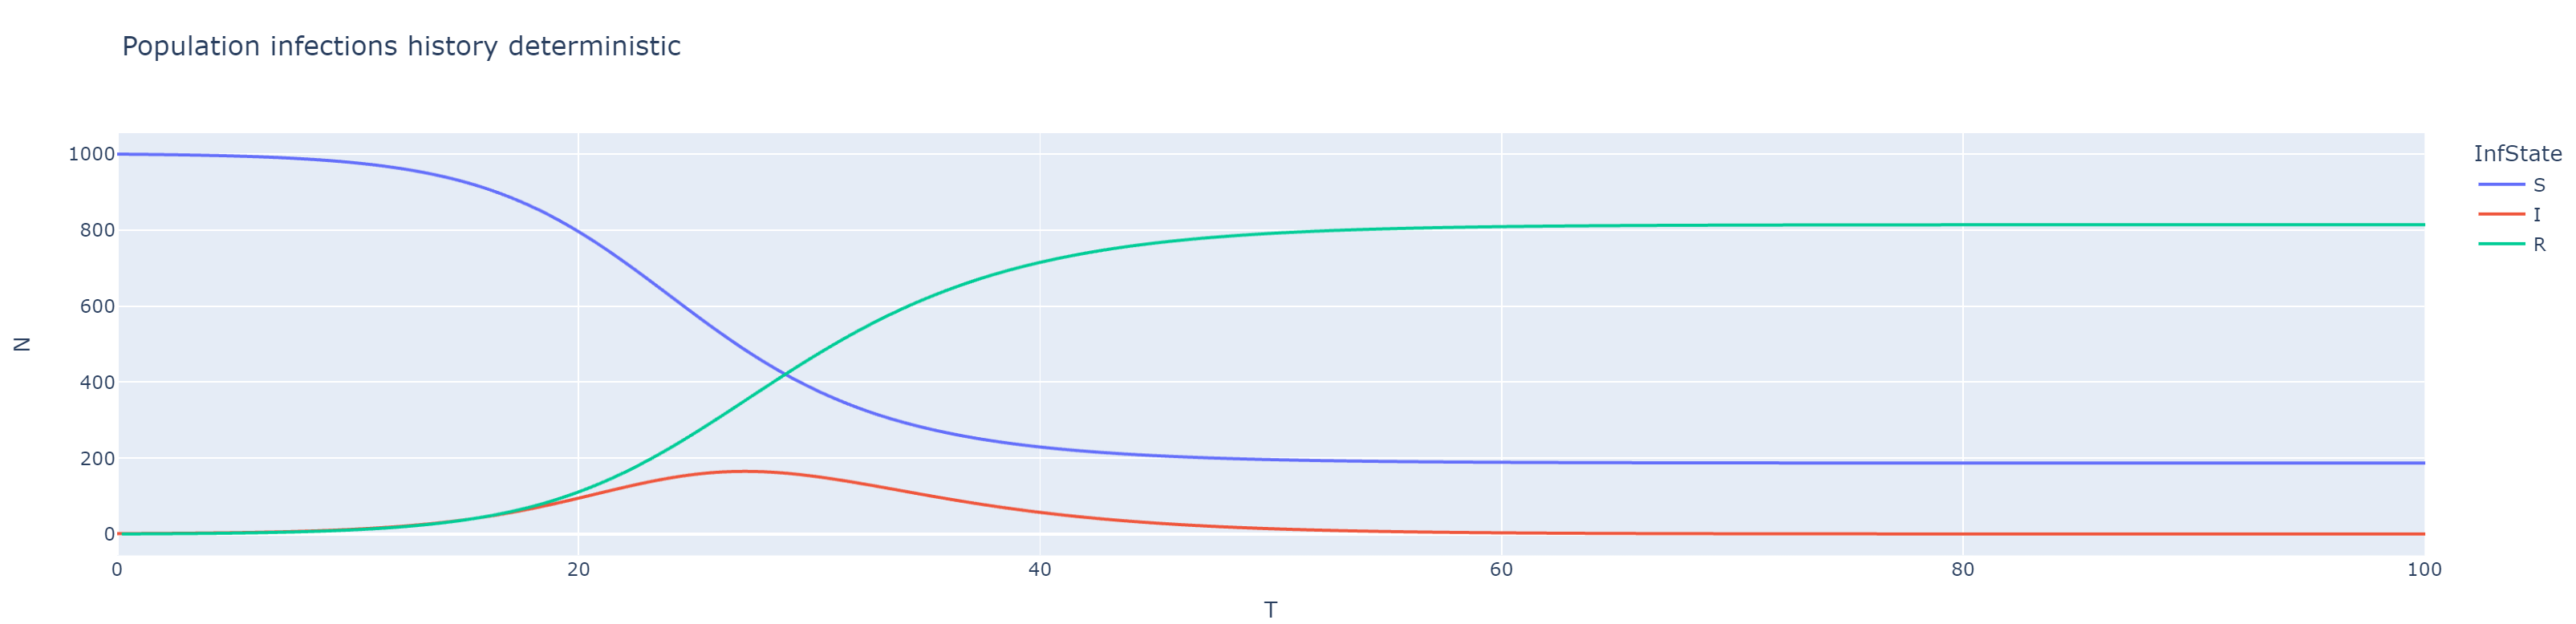

## Making and Running a Stochastic Epidemic Model

There are two  ways to set up a stochastic epidemic model. One is to specify stochasticity at the rule level, the other is to do so at the model level. Here we will use the same rules as before and set up stochasticity at the model level. 

In [6]:
stoch_epi_mdl = tepi.EpiModel(init_state=population, rules = [infect_rule, recover_rule], stoch_policy="stochastic")

Running a single model is the same as for deterministic

In [7]:
for i in range(400):
    stoch_epi_mdl.do_timestep(dt=0.25)

stoch_epi_fig = px.line(stoch_epi_mdl.full_epi, x="T", y="N", color="InfState", title='Population infections history stochastic')
stoch_epi_fig.show()

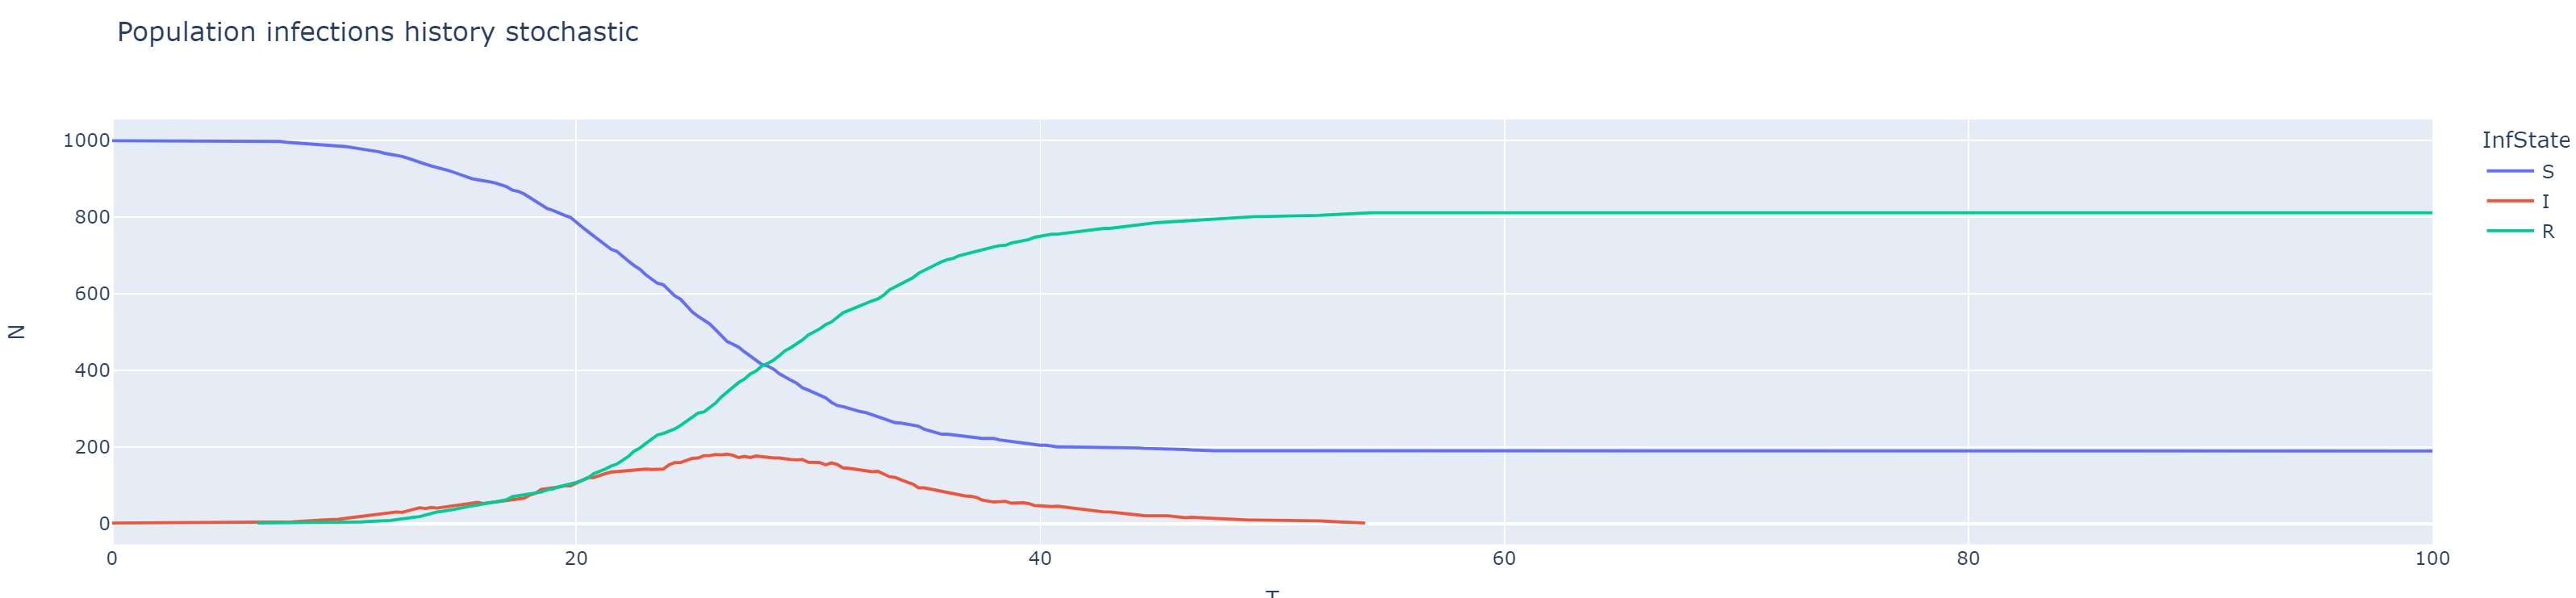

Using the 'reset' function makes it ease for us to run multiple stochastic simulations.

In [8]:
#Do 100 simulations concatenating together. 
all_sims = pd.DataFrame() #change all_sims from list to dataframe type

for i in range(20):
    stoch_epi_mdl.reset()
    for j in range(400):
        stoch_epi_mdl.do_timestep(dt=0.25)
    tmp = stoch_epi_mdl.full_epi
    tmp['sim'] = i
    all_sims = pd.concat([all_sims,tmp]) #save each full_epi from simulations
    
all_sims = all_sims.reset_index(drop=True)

In [9]:
all_sims_infected_people = all_sims[all_sims['InfState']=='I'] #extract infected people data
all_sims_infected_people


,InfState,N,T,sim
1,I,1,0.00,0
2,I,1,0.25,0
4,I,1,0.50,0
6,I,1,0.75,0
8,I,1,1.00,0
...,...,...,...,...
16274,I,1,0.25,18
17075,I,1,0.00,19
17076,I,1,0.25,19
17078,I,1,0.50,19


In [10]:
#Plot each simulation's infected population data
stoch_simple_sir_fig = px.line(all_sims_infected_people, x="T", y="N", color="sim", title='infected population in 100 time units')
stoch_simple_sir_fig.show()

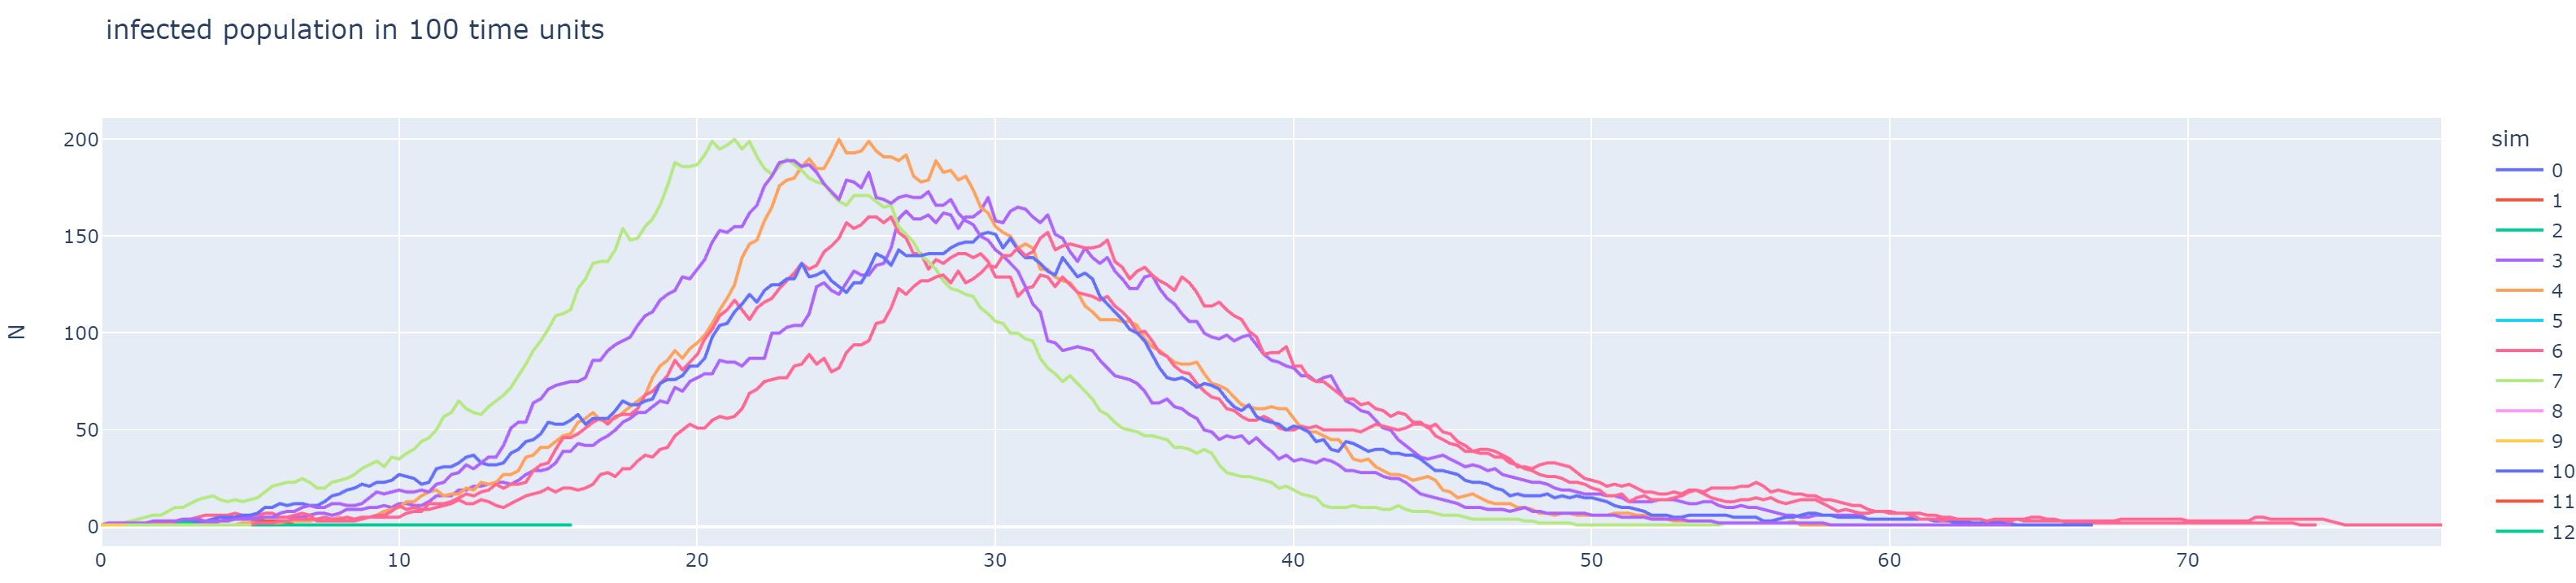

### Lowess Model

In [11]:
# Apply LOWESS smoothing to get the regression line
smoothed = lowess(endog = all_sims_infected_people['N'], exog = all_sims_infected_people['T'], frac=0.05, return_sorted = True)
smoothed

array([[ 0.        ,  1.01970456],
       [ 0.        ,  1.01970456],
       [ 0.        ,  1.01970456],
       ...,
       [78.        ,  1.23187085],
       [78.25      ,  1.1661323 ],
       [78.5       ,  1.09967875]])

In [12]:
# Create a scatter plot for the infected people
fig_smoothed = px.scatter(all_sims_infected_people, x='T', y='N', opacity=0.1)

# Add the regression line to the plot
fig_smoothed.add_trace(go.Scatter(x=smoothed[:, 0], y=smoothed[:, 1],
                         mode='lines', line=dict(color='blue'),
                         name='Regression Line'))

# Customize the layout
fig_smoothed.update_layout(
    title="Simulations of Inected People and Regression Line",
    xaxis_title="T",
    yaxis_title="N",
    showlegend=True
)

# Show the interactive plot
fig_smoothed.show()

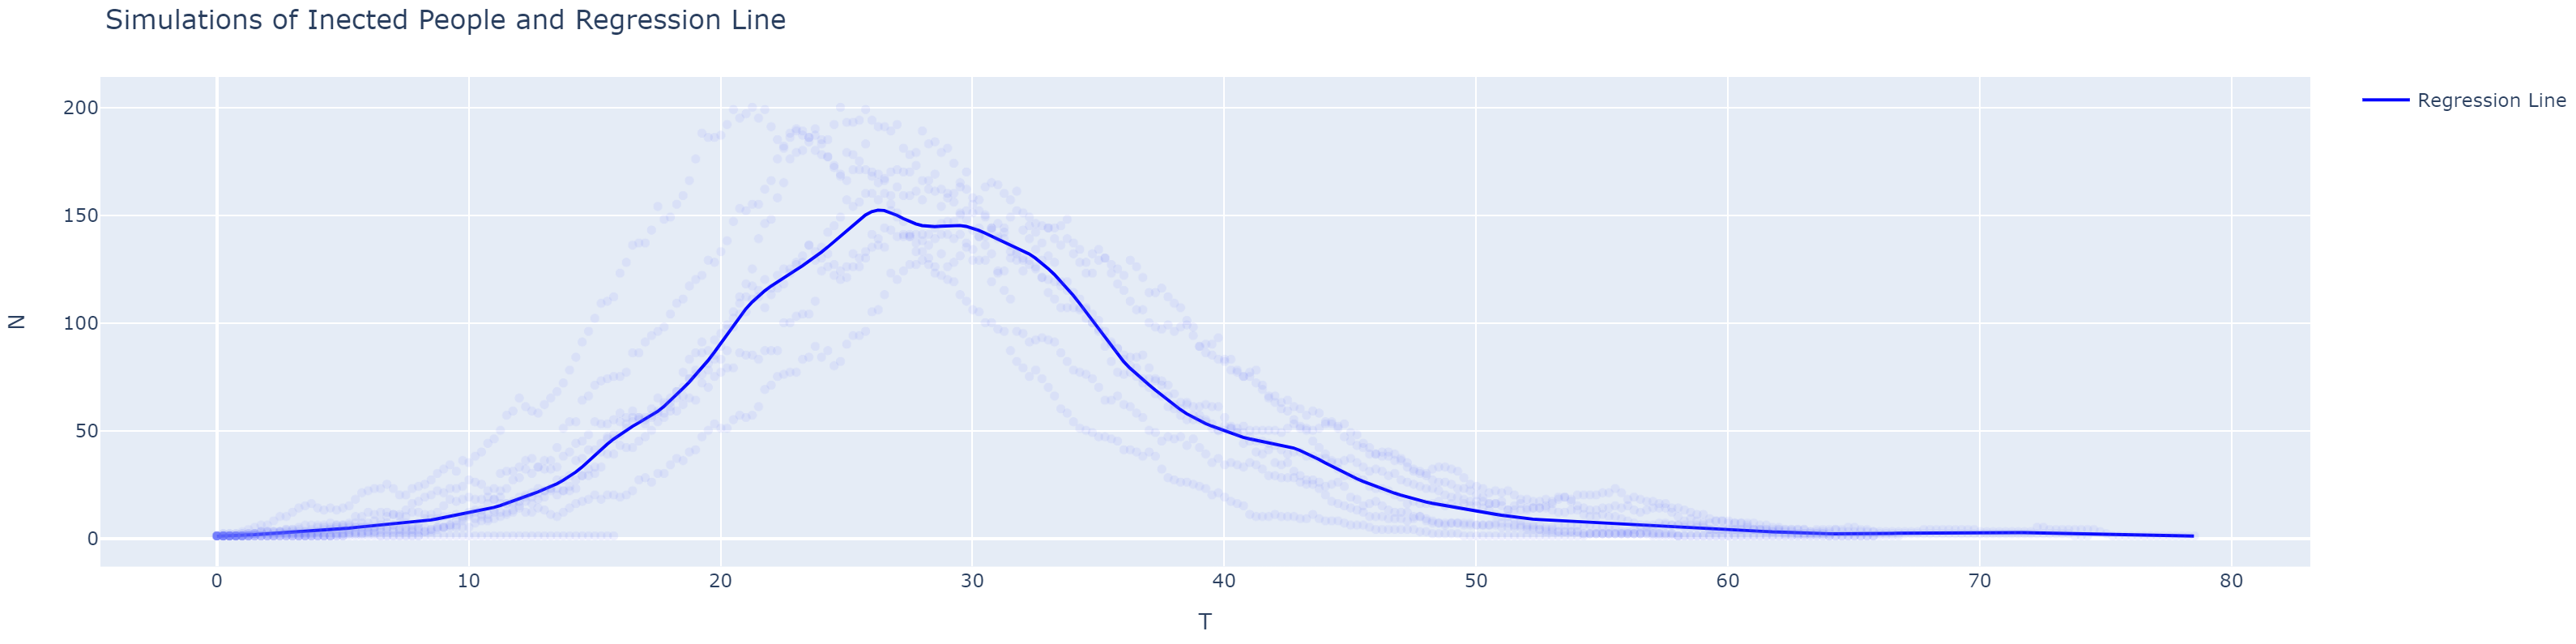

### Adding Confidence Interval to the Regression Line

In [13]:
n_bootstraps=1000 #re-sample 1000 times
df_bootstrap = all_sims_infected_people.copy()
smoothed_values = []

In [14]:
for i in range(n_bootstraps):
    sample_df = df_bootstrap.sample(frac=1, replace=True)
    smoothed_sample = lowess(sample_df['N'], sample_df['T'], frac=0.05) #fit data to lowess function
    smoothed_values.append(smoothed_sample[:, 1])

In [15]:
#95% confidenc interval
ci = 95
smoothed_values = np.array(smoothed_values)
lower_ci = np.percentile(smoothed_values, (100-ci)/2, axis=0) #2.5% boundary
upper_ci = np.percentile(smoothed_values, ci+(100-ci)/2, axis=0) #97.5% boundary

In [16]:
# Create another scatter plot for the infected people and include regression line and confidence interval
fig_smoothed_with_ci = px.scatter(all_sims_infected_people, x='T', y='N', opacity=0.1)
fig_smoothed_with_ci.add_trace(go.Scatter(x=smoothed[:, 0], y=smoothed[:, 1],
                         mode='lines', line=dict(color='blue'),
                         name='Regression Line'))

# Add confidence intervals as a shaded area
fig_smoothed_with_ci.add_trace(go.Scatter(
    x=smoothed[:, 0], y=lower_ci,
    fill=None, mode='lines', line_color='lightblue', name='Lower CI'))

fig_smoothed_with_ci.add_trace(go.Scatter(
    x=smoothed[:, 0], y=upper_ci,
    fill='tonexty', mode='lines', line_color='lightblue', name='Upper CI',
    fillcolor='rgba(173, 216, 230, 0.3)'  # Light blue shaded area
))

# Customize layout
fig_smoothed_with_ci.update_layout(
    title="Simulations of Inected People with Regression Line and Confidence Interval",
    xaxis_title="T",
    yaxis_title="N",
    showlegend=True
)

fig_smoothed_with_ci.show()

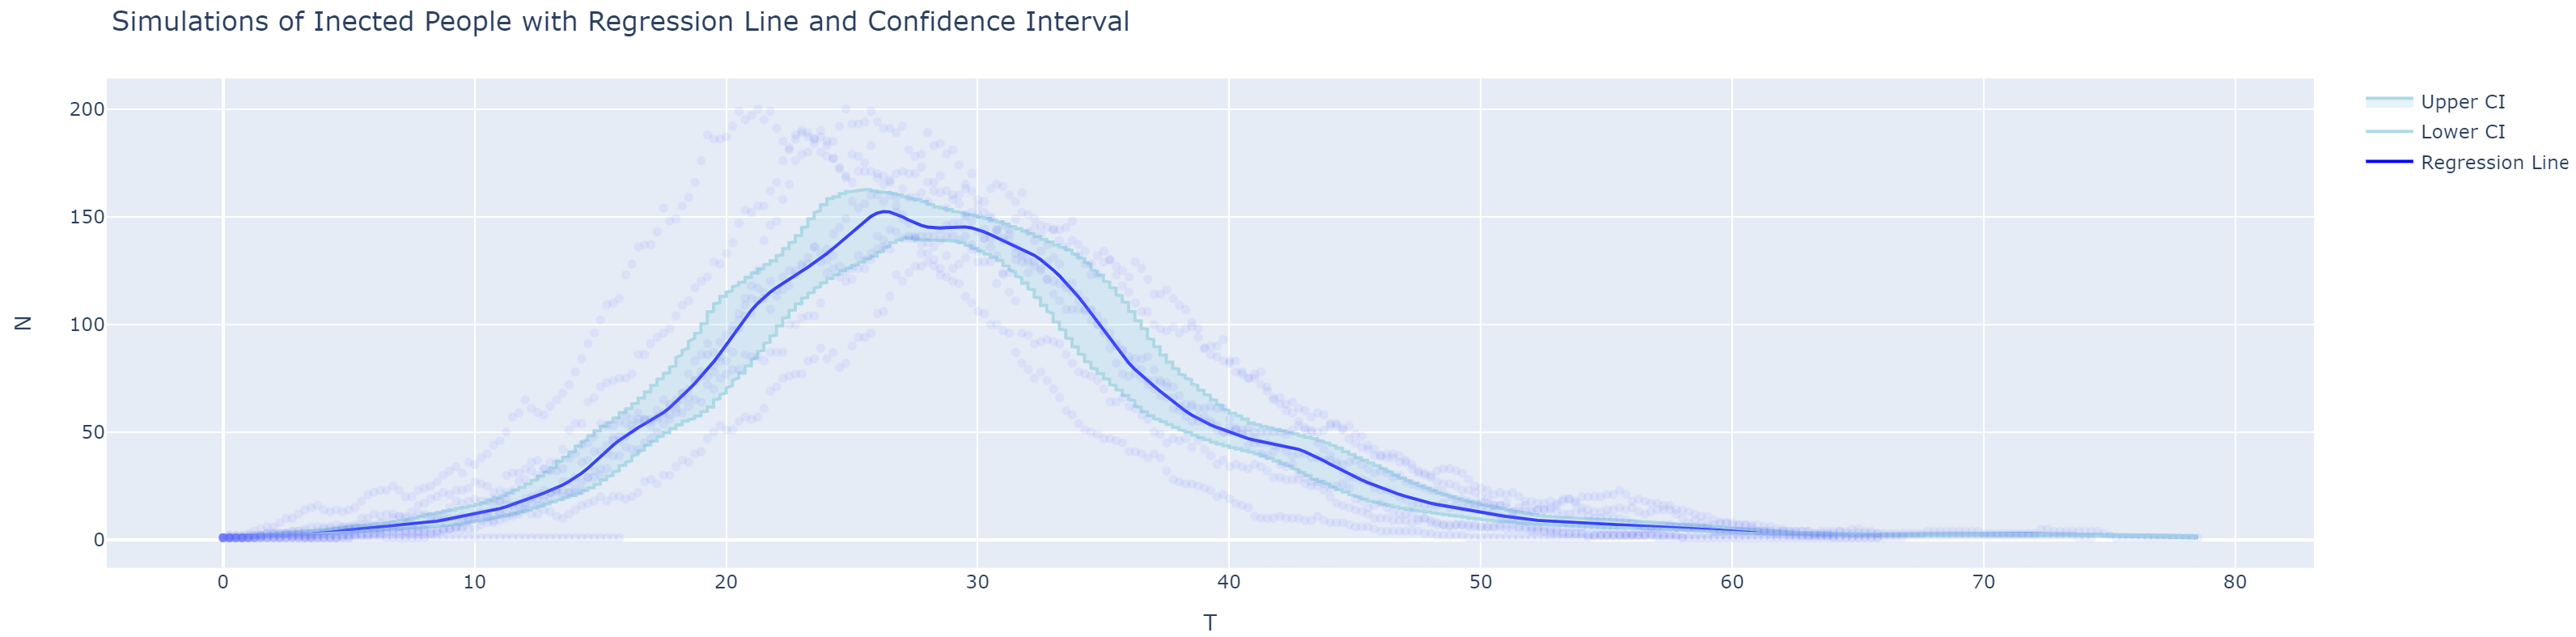

## Adding an Stochastic Observation Process to a Determinsitic Model

We can add a stochstic observation process to a deterministic (or stochastic) model. First we add the observation column to the population, than create an epi model with blended stochastic and deterministic rules. 

In [17]:
#Creeate a hospitalization column with everyone unobserved
population_new = population.copy()
population_new['Hosp'] = 'U'
population_new

,InfState,N,T,Hosp
0,S,999,0.0,U
1,I,1,0.0,U


In [18]:
#Create the hospitalization rule. Everyone has a 5% chance of being hospitalized per day infected
hosp_rule = tepi.SimpleObservationProcess(source_col="InfState",source_state="I", obs_col="Hosp", rate=.05, stochastic=True)

#Create the epi model
hosp_obs_mdl = tepi.EpiModel(init_state = population_new, rules = [ [infect_rule, recover_rule], [hosp_rule] ])

for i in range(400):
    hosp_obs_mdl.do_timestep(dt=0.25)

hosp_res = hosp_obs_mdl.full_epi #save full epi history to hopsitalization result

In [19]:
# Floor the 'T' values
hosp_res['T'] = np.floor(hosp_res['T'])

In [20]:
#Sum of N where Hosp == "I", Sum of N where InfState == "I"
hosp_inf = hosp_res.groupby('T').agg(
    Hosp_Incident=pd.NamedAgg(column='N', aggfunc=lambda x: (x[hosp_res['Hosp'] == 'I']).sum()), 
    InfState_Infect =  pd.NamedAgg(column='N', aggfunc=lambda x: (x[hosp_res['InfState'] == 'I']).sum()) 
).reset_index()
hosp_inf.head()

,T,Hosp_Incident,InfState_Infect
0,0.0,0.0,4.402402
1,1.0,0.0,5.647092
2,2.0,0.0,7.241346
3,3.0,0.0,9.281824
4,4.0,0.0,11.890943


Note that when we plot infections we need to take into account the various observed states.

In [21]:
# Create a image with two separate plots (one for Hosp, one for I)
fig_hosp_infstate = make_subplots(
    rows=1, cols=2, 
    subplot_titles=("Hosp_Incident", "InfState_Infect"),
    shared_xaxes=True
)

# Add the trace for Hosp to the first subplot (left)
fig_hosp_infstate.add_trace(
    go.Scatter(x=hosp_inf['T'], y=hosp_inf['Hosp_Incident'], mode='lines', name='Hosp Incident-observed Count',
               line=dict(color='blue')),
    row=1, col=1
)

# Add the trace for InfState to the second subplot (right)
fig_hosp_infstate.add_trace(
    go.Scatter(x=hosp_inf['T'], y=hosp_inf['InfState_Infect'], mode='lines', name='InfState Infected Count',
               line=dict(color='red')),
    row=1, col=2
)

# Update layout for the entire figure
fig_hosp_infstate.update_layout(
    title={
        'text': "Hosp_Incident and InfState_Infect over Time",
        'x': 0.5,
        'xanchor': 'center'
    },
    xaxis_title="Time (T)",
    xaxis2_title="Time (T)",
)

# Left subplot: y-axis for Hosp
fig_hosp_infstate.update_yaxes(title_text="Count (Hosp==Incident-observed)", row=1, col=1)

# Right subplot: y-axis for I
fig_hosp_infstate.update_yaxes(title_text="Count (InfState==Infected)", row=1, col=2)

# Show the plot
fig_hosp_infstate.show()

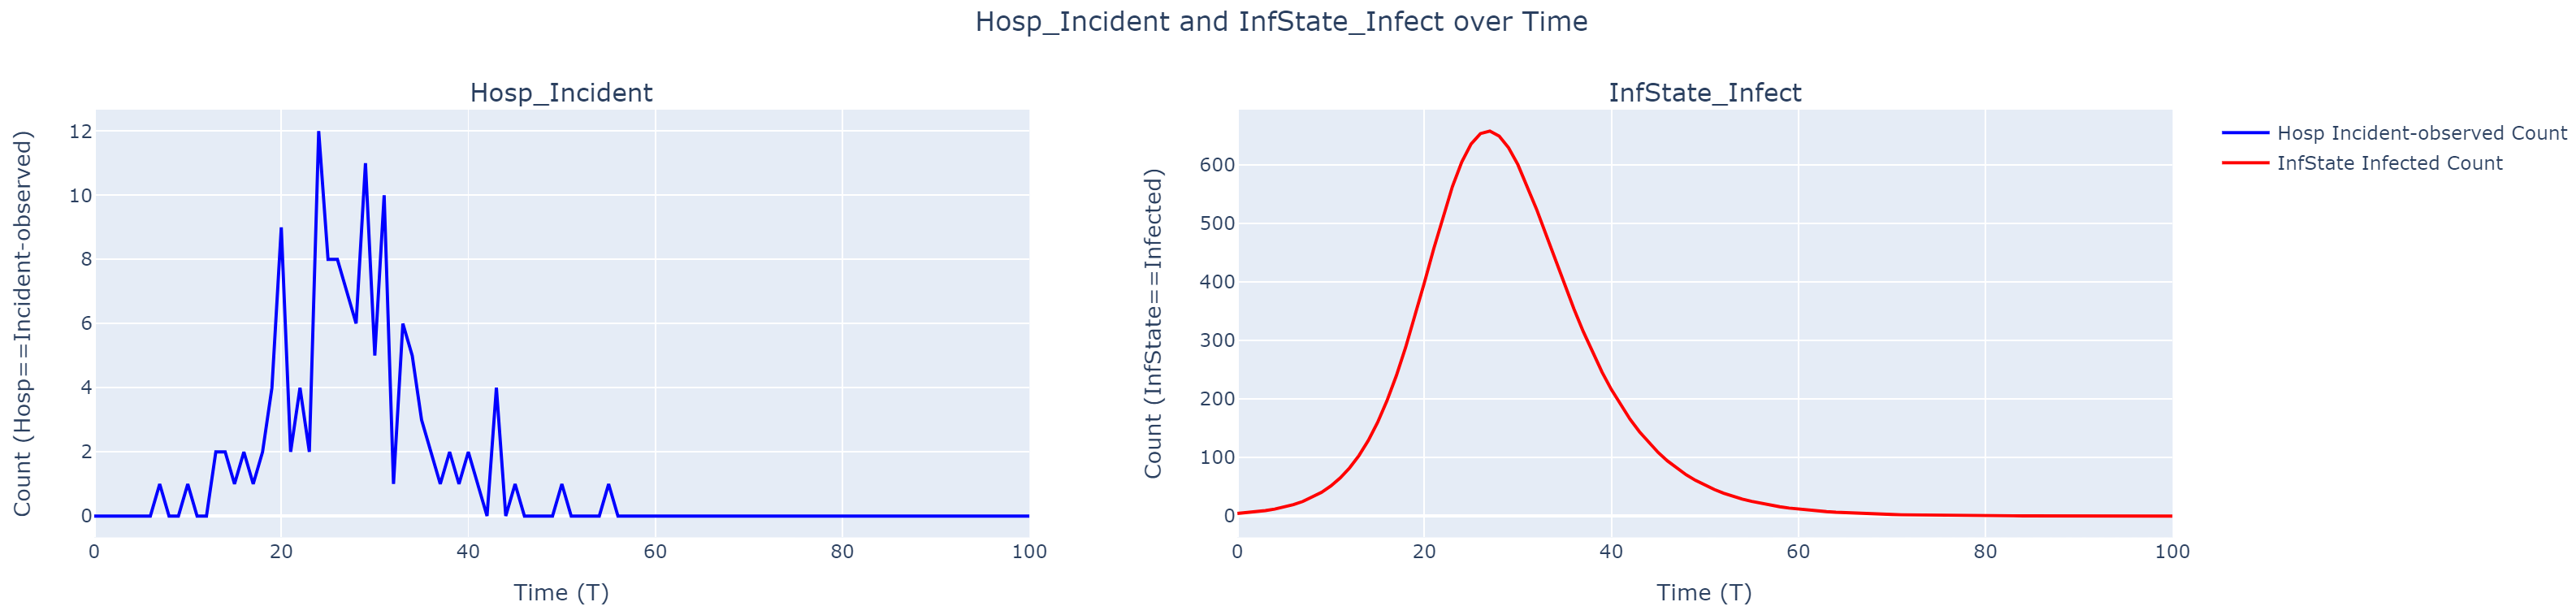